# Using Time Series to Forecast Sales

Within this project, I carried out exploritative data analysis how to use sales data to predict the sales of a company over a 3 month period. From this analysis, I hope to accurately predict the amount of stock which best suits the store at a given time. This will help to ensure wasting numbers remain low whilst ensuring stock meets the demand of the students. 

The dataset I'll be uses was created by _Mohamed Harris_

**1) Exploring**

To begin this project, I spent time understanding the features of the dataset. I imported the necessary libraries to do such an analysis. Here I saw the types of data that was being store within the data-frame. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

#importing dataframe
df = pd.read_csv("Supermart Grocery Sales - Retail Analytics Dataset.csv")

#importing state
df.drop(columns="State")

df.head(3)

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu


**2) Data Cleaning**

For analysis, I ensured the data that was used was consistant. I simplified the data to ensure only what was relevant was used for the base model, which in this case was the orders, categories and sales data. 

In [5]:
# Observed that "Order Date" has an inconsistant format, which would create issues when converting into a dateTime object
df.tail(3)

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
9991,OD9992,Ravi,Food Grains,Rice,Bodi,06-06-2017,West,1567,0.16,501.44,Tamil Nadu
9992,OD9993,Peer,Oil & Masala,Spices,Pudukottai,10/16/2018,West,1659,0.15,597.24,Tamil Nadu
9993,OD9994,Ganesh,Food Grains,Atta & Flour,Tirunelveli,4/17/2018,West,1034,0.28,165.44,Tamil Nadu


In [6]:
#Replaced any / with - to ensure the format was consistant 
df["Order Date"] = df["Order Date"].astype(str).str.replace("/", "-", regex=False)
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")

#Dropping less relevant data columns
df_g = df.drop(columns=["Order ID", "Customer Name", "Sub Category", "City", "Discount", "State", "Region"])
df_g = df.dropna(subset="Order Date")

#Grouped the orders by date and category.
df_g = df.groupby(["Order Date", "Category"]).sum().reset_index()
df_a = df.groupby("Order Date").sum().reset_index()

df_g.sort_values(by="Order Date")

#only within a specific year, in this case only 2015
filtered_df = df_g[df_g["Order Date"] < pd.to_datetime("2016-01-01")]


After filtering this data, I then constructed a graph to showcase the sales that had occured within the bakery. This also helped me to identify if their were any anomolies within the data. 

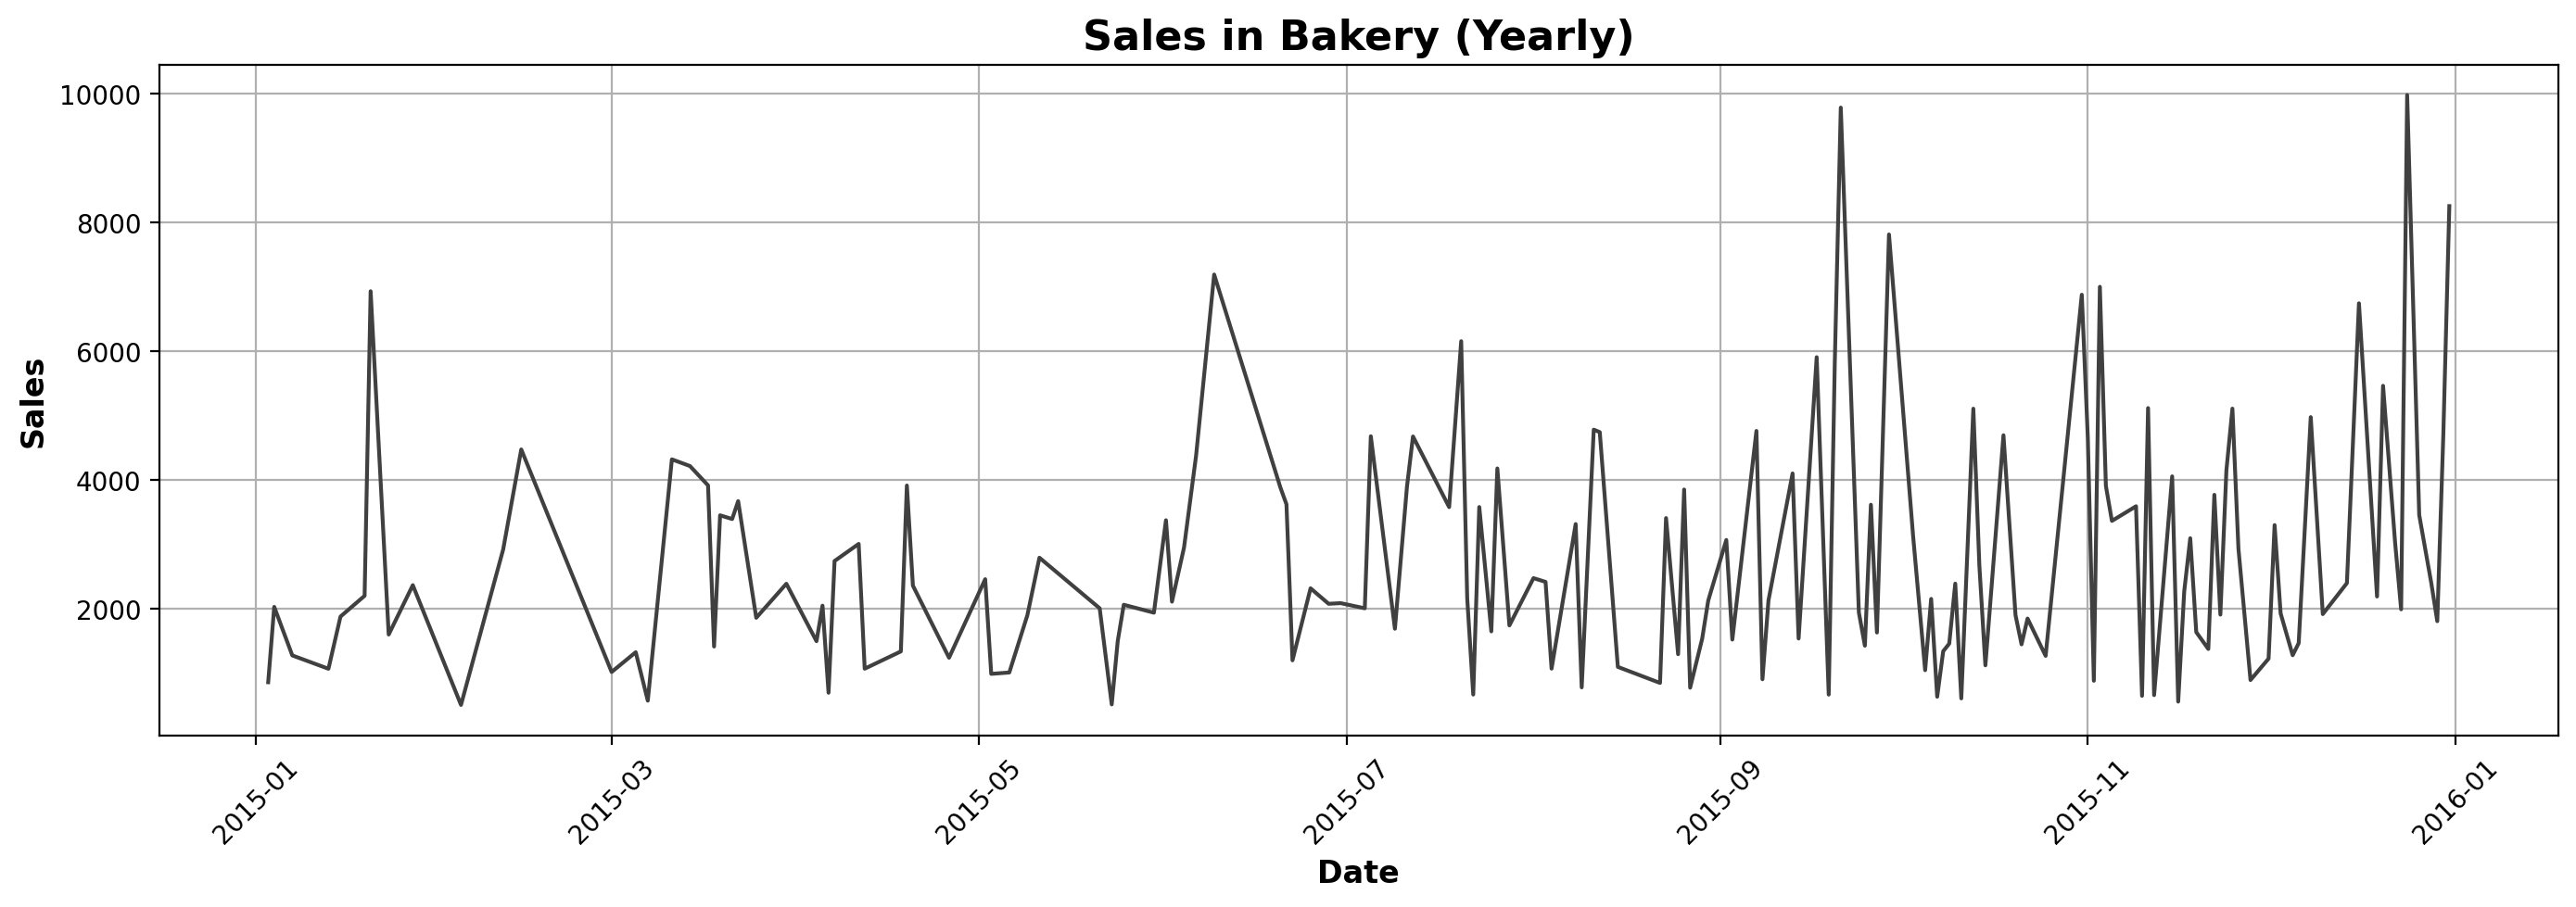

In [7]:
#plot the relevant sales data over time
plt.style.use("seaborn-v0_8-pastel")
plt.rc("figure", autolayout=True, figsize=(14, 5))  # Wider figure
plt.rc("axes", grid=True, labelsize='large', labelweight='bold', titlesize=16, titleweight='bold')
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()

#Graph Labels
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_title("Sales in Bakery (Yearly)")
plt.xticks(rotation=45)

ax.plot('Order Date', 'Sales', data=filtered_df[filtered_df["Category"] == "Bakery"], color='0.25')

<BarContainer object of 51 artists>

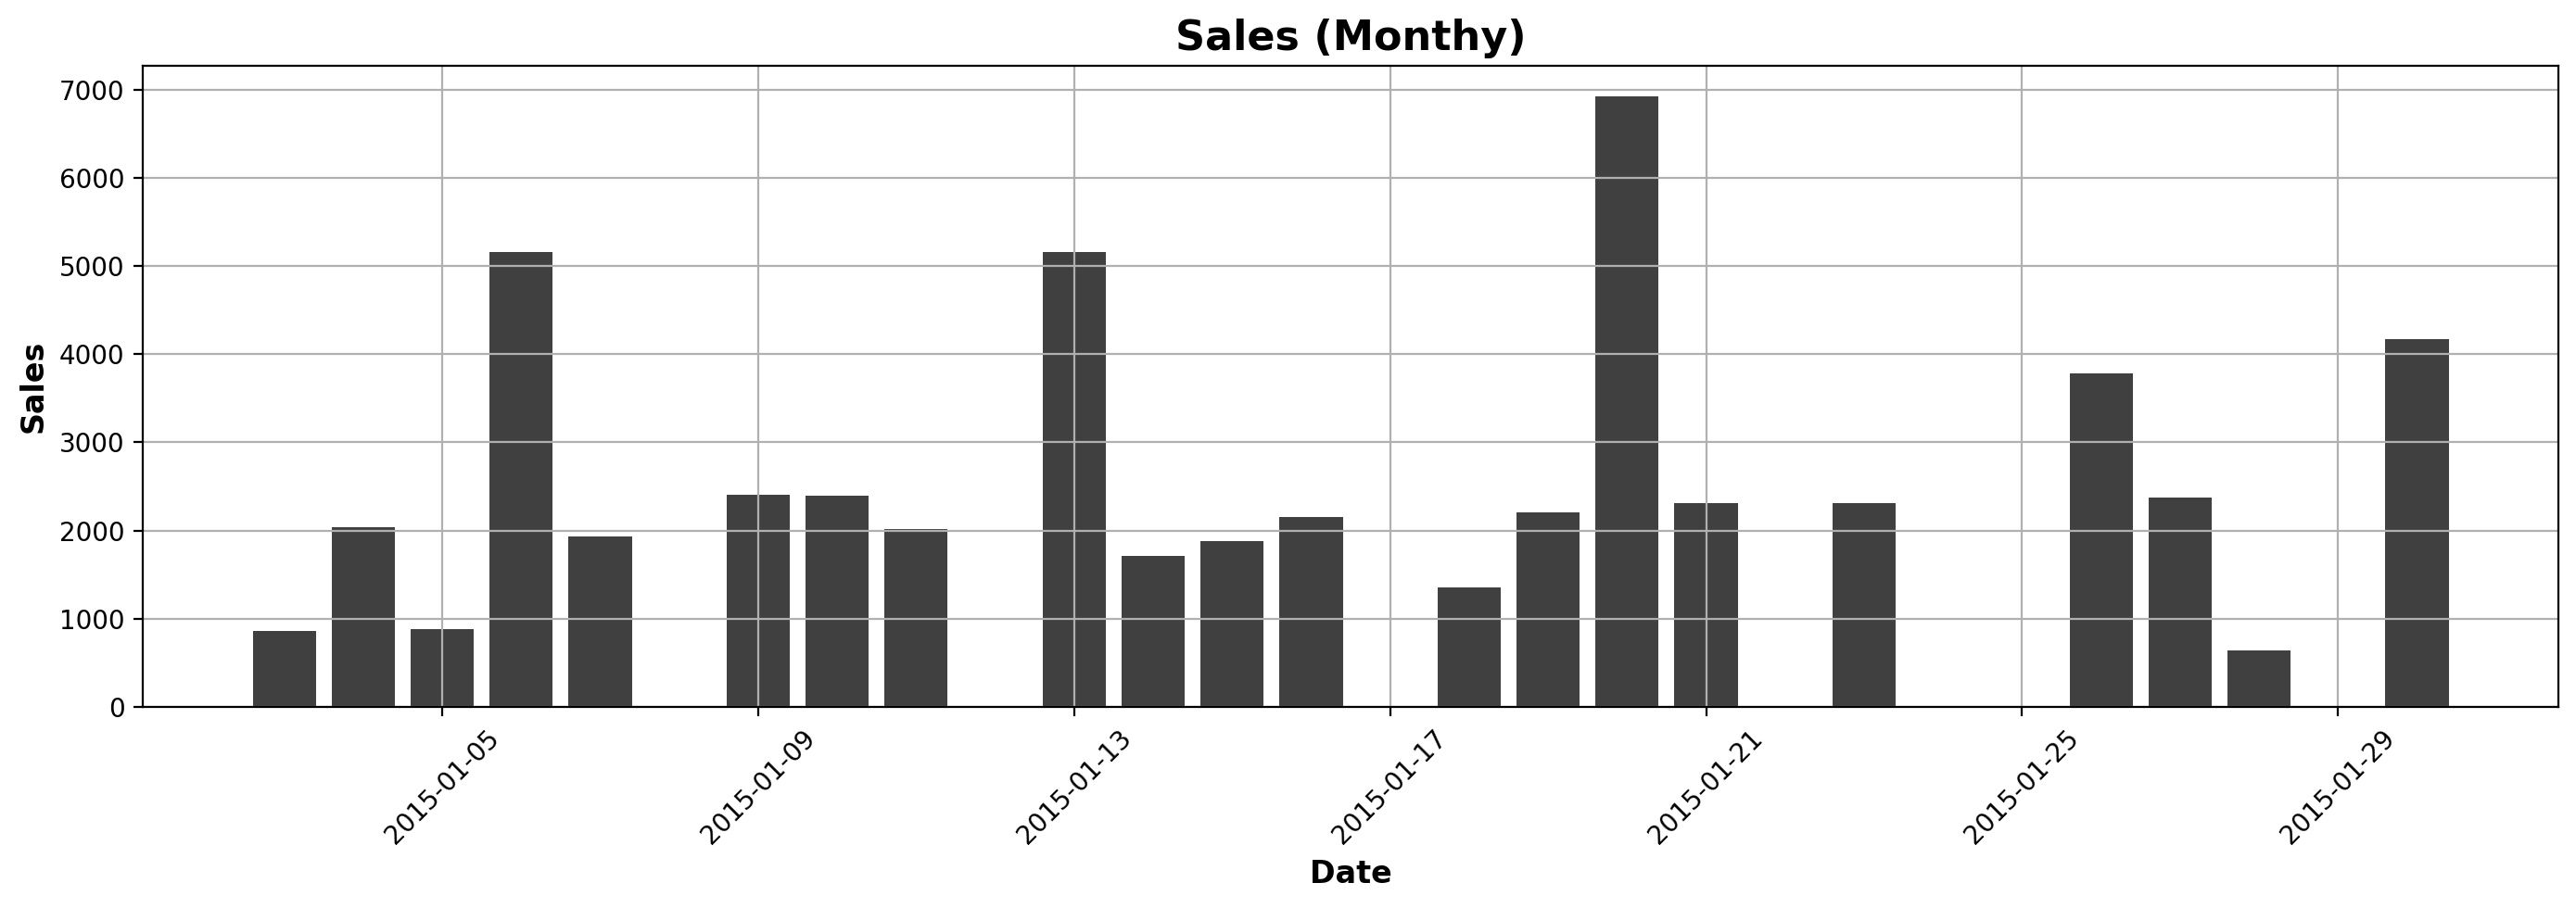

In [7]:
#plot the relevant sales data over time
plt.style.use("seaborn-v0_8-pastel")
plt.rc("figure", autolayout=True, figsize=(14, 5))  # Wider figure
plt.rc("axes", grid=True, labelsize='large', labelweight='bold', titlesize=16, titleweight='bold')
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()

#Graph Labels
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
plt.xticks(rotation=45)
ax.set_title('Sales (Monthy)');

#Only within a specific month
filtered_df_a = df_g[df_g["Order Date"] < pd.to_datetime("2015-01-31")]

ax.bar('Order Date', 'Sales', data=filtered_df_a, color='0.25')


**3) Forecasting** 

After deploying the forecast, I cleaned the data again by removing less necessary dataframe columns for the sales forecast. I created two lag phases by shifting each value by 2.

In [9]:
sdf_a = df_a.drop(columns=["Profit", "Discount", "State", "Region", "Order ID", "Customer Name", "Category", "Sub Category", "City"])
sdf_a = sdf_a.set_index("Order Date")
sdf_a = pd.DataFrame({
    "y": sdf_a["Sales"],
    "y_lag_1": sdf_a["Sales"].shift(1),
    "y_lag_2": sdf_a["Sales"].shift(2),
})
sdf_a.tail()

,y,y_lag_1,y_lag_2
Order Date,,,
2018-12-26,4711,32360.0,25809.0
2018-12-27,3575,4711.0,32360.0
2018-12-28,25875,3575.0,4711.0
2018-12-29,16932,25875.0,3575.0
2018-12-30,9152,16932.0,25875.0


**4) Detrending**
 
The next stage was to detrend the data of it's seasonal characterists. From the previous EDA, I had noticed that winter months do oncurr a higher number of sales. Hense, why I decided to apply an event specific feature to ensure that sales aren't effected. A deterministic process worked well in modelling the trends

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

sdf_a2 = sdf_a[(sdf_a.index >= '2018-01-01') & (sdf_a.index < '2019-01-01')]
y = sdf_a2.loc[:, 'y'].squeeze() # selects the column y
y = y.resample("D").sum()

fourier = CalendarFourier(freq='ME', order=2) #selects the order number

dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)

X_time = dp.in_sample()
X_time['Winter Period'] = (X_time.index.dayofyear > 305)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

Once the model was trained and the data was deseasoned, the deseasoned prediction was plotted on the graph along side a 31 month rolling average to smoothly measure the trajectory of the graph. This was to compare if this was an effective methodolody.

Text(0.5, 1.0, '31 Day Moving Average')

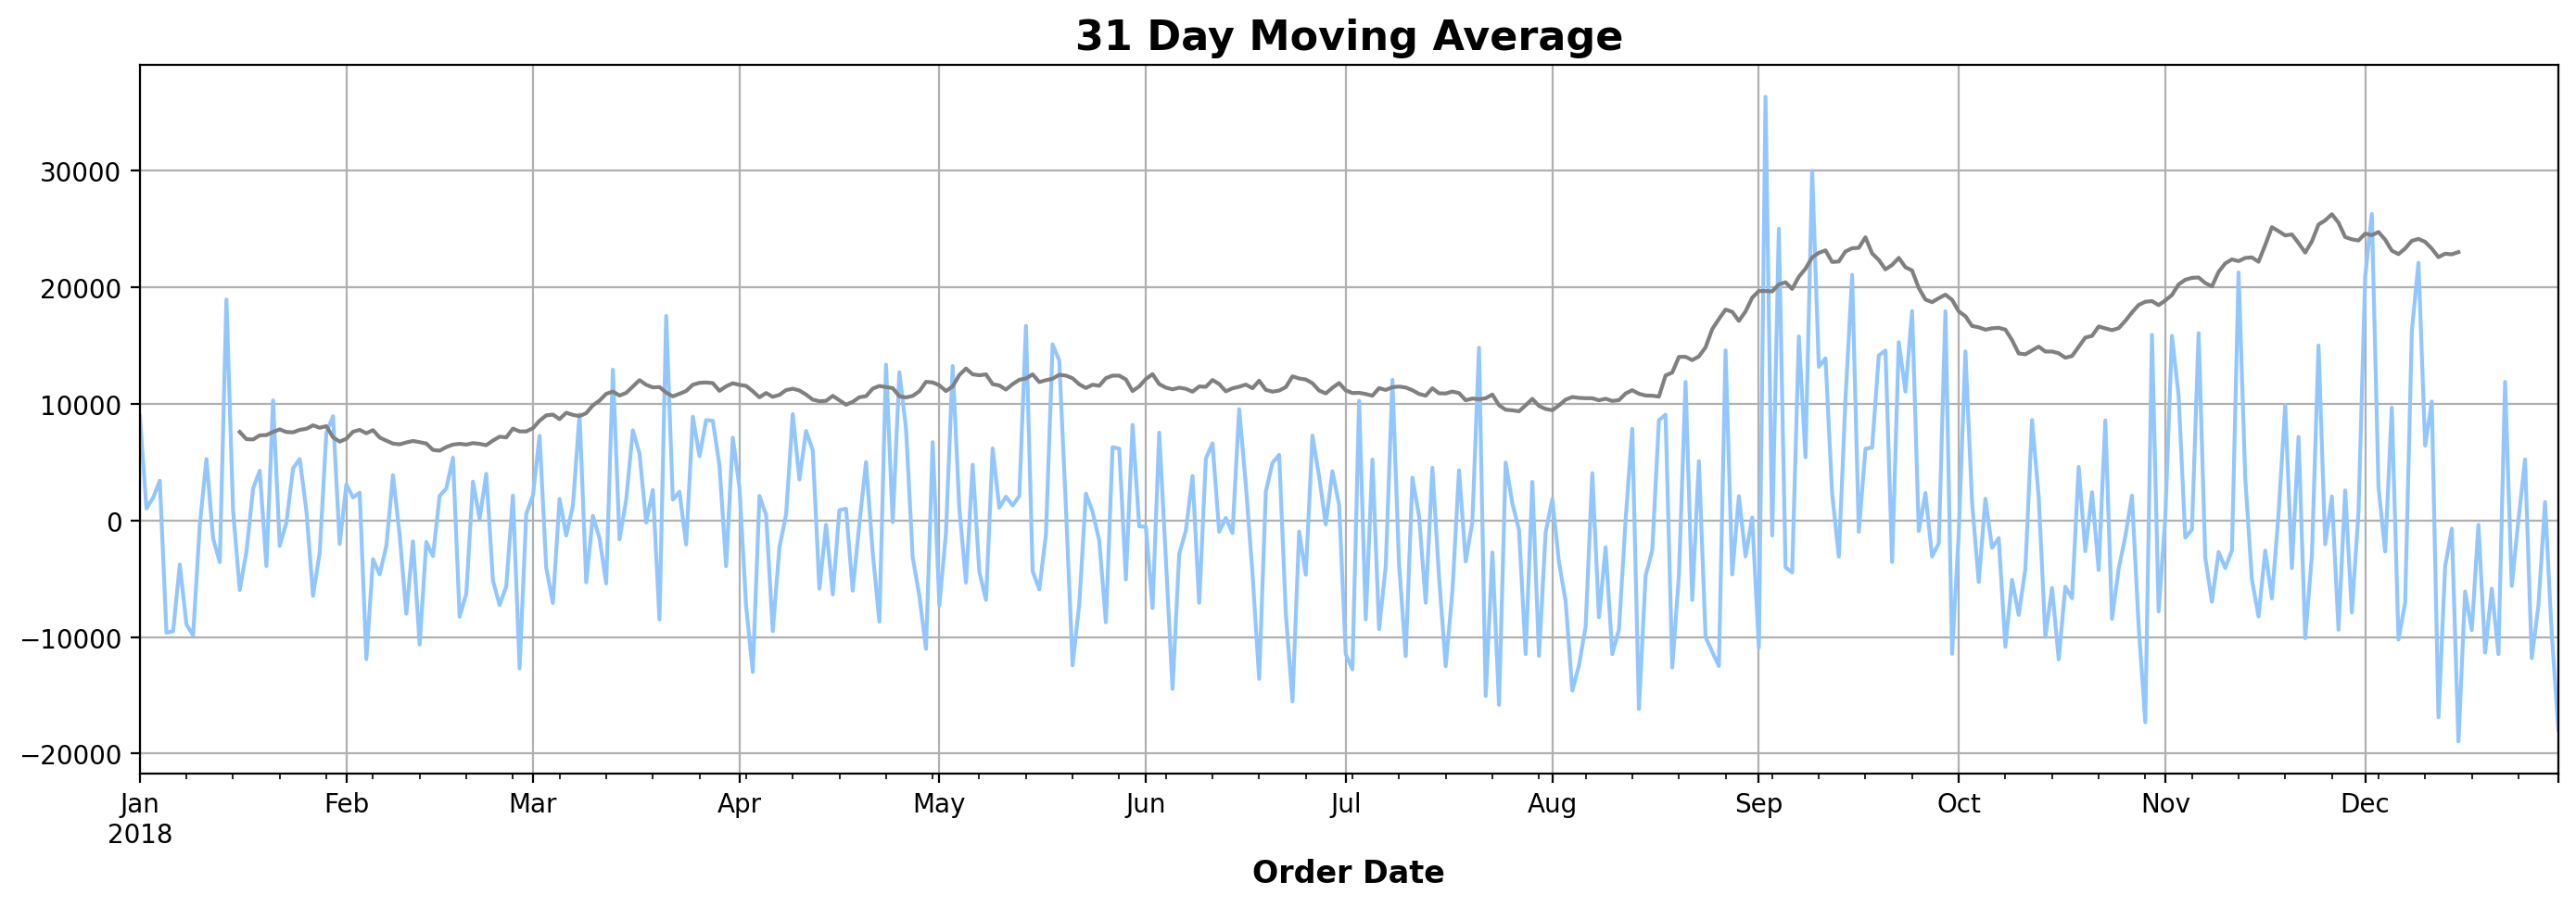

In [13]:
ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");

y_ma = y.rolling(31, center=True).mean()
ax = y_ma.plot(color="0.5")
ax.set_title("31 Day Moving Average")

**5) Structuring Dataframe for Predictions**

To structure out data for our predictions, we'll create 2 new functions. One "make_lags" which will produce a new lag column based on the data found in the dataset. Shifting values backwards. Whereas "make_steps" will be shifting data forwards. I made the forcast horizon 2 steps to simplify the prediction and complexity, minimizing the change for errors. In particular propagation errors.

In [15]:
def make_lags(df, lags, lead_time=1):
    return pd.concat(
        {f'y_lag_{i}': df.shift(i)
         for i in range(lead_time, lags + lead_time)
        },axis=1)

def make_steps(df, steps):
    return pd.concat(
        {f'y_step_{i + 1}': df.shift(-i)
         for i in range(steps)},
        axis=1)

y = sdf_a2
X = make_lags(y, lags=4).fillna(0.0)
y = make_steps(y, steps=2).dropna() #2 step forward for simplicity

# Only keeping times for which we have both targets and features, all other values are dropped.
y, X = y.align(X, join='inner', axis=0)

Using out trained data, we can split up out dataframe 25/75, and use the 25% to act as our prediction standard, and the 75% as our means of modelling those results.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

**6) Visualizing Model**

Now that we have our data, we can visualize this model through the use of a line graph. We can also describe the accuracy of the model through the use of the Root Mean Squared Error. What is evident is the models ability to model well the moving average sales within the data, however, what isn't represented modelled as well is the larger variations within the model. Further updates will be implemented to adjust for this discrepancy. The amplitude should also altered in the process, which would also be corrected for.

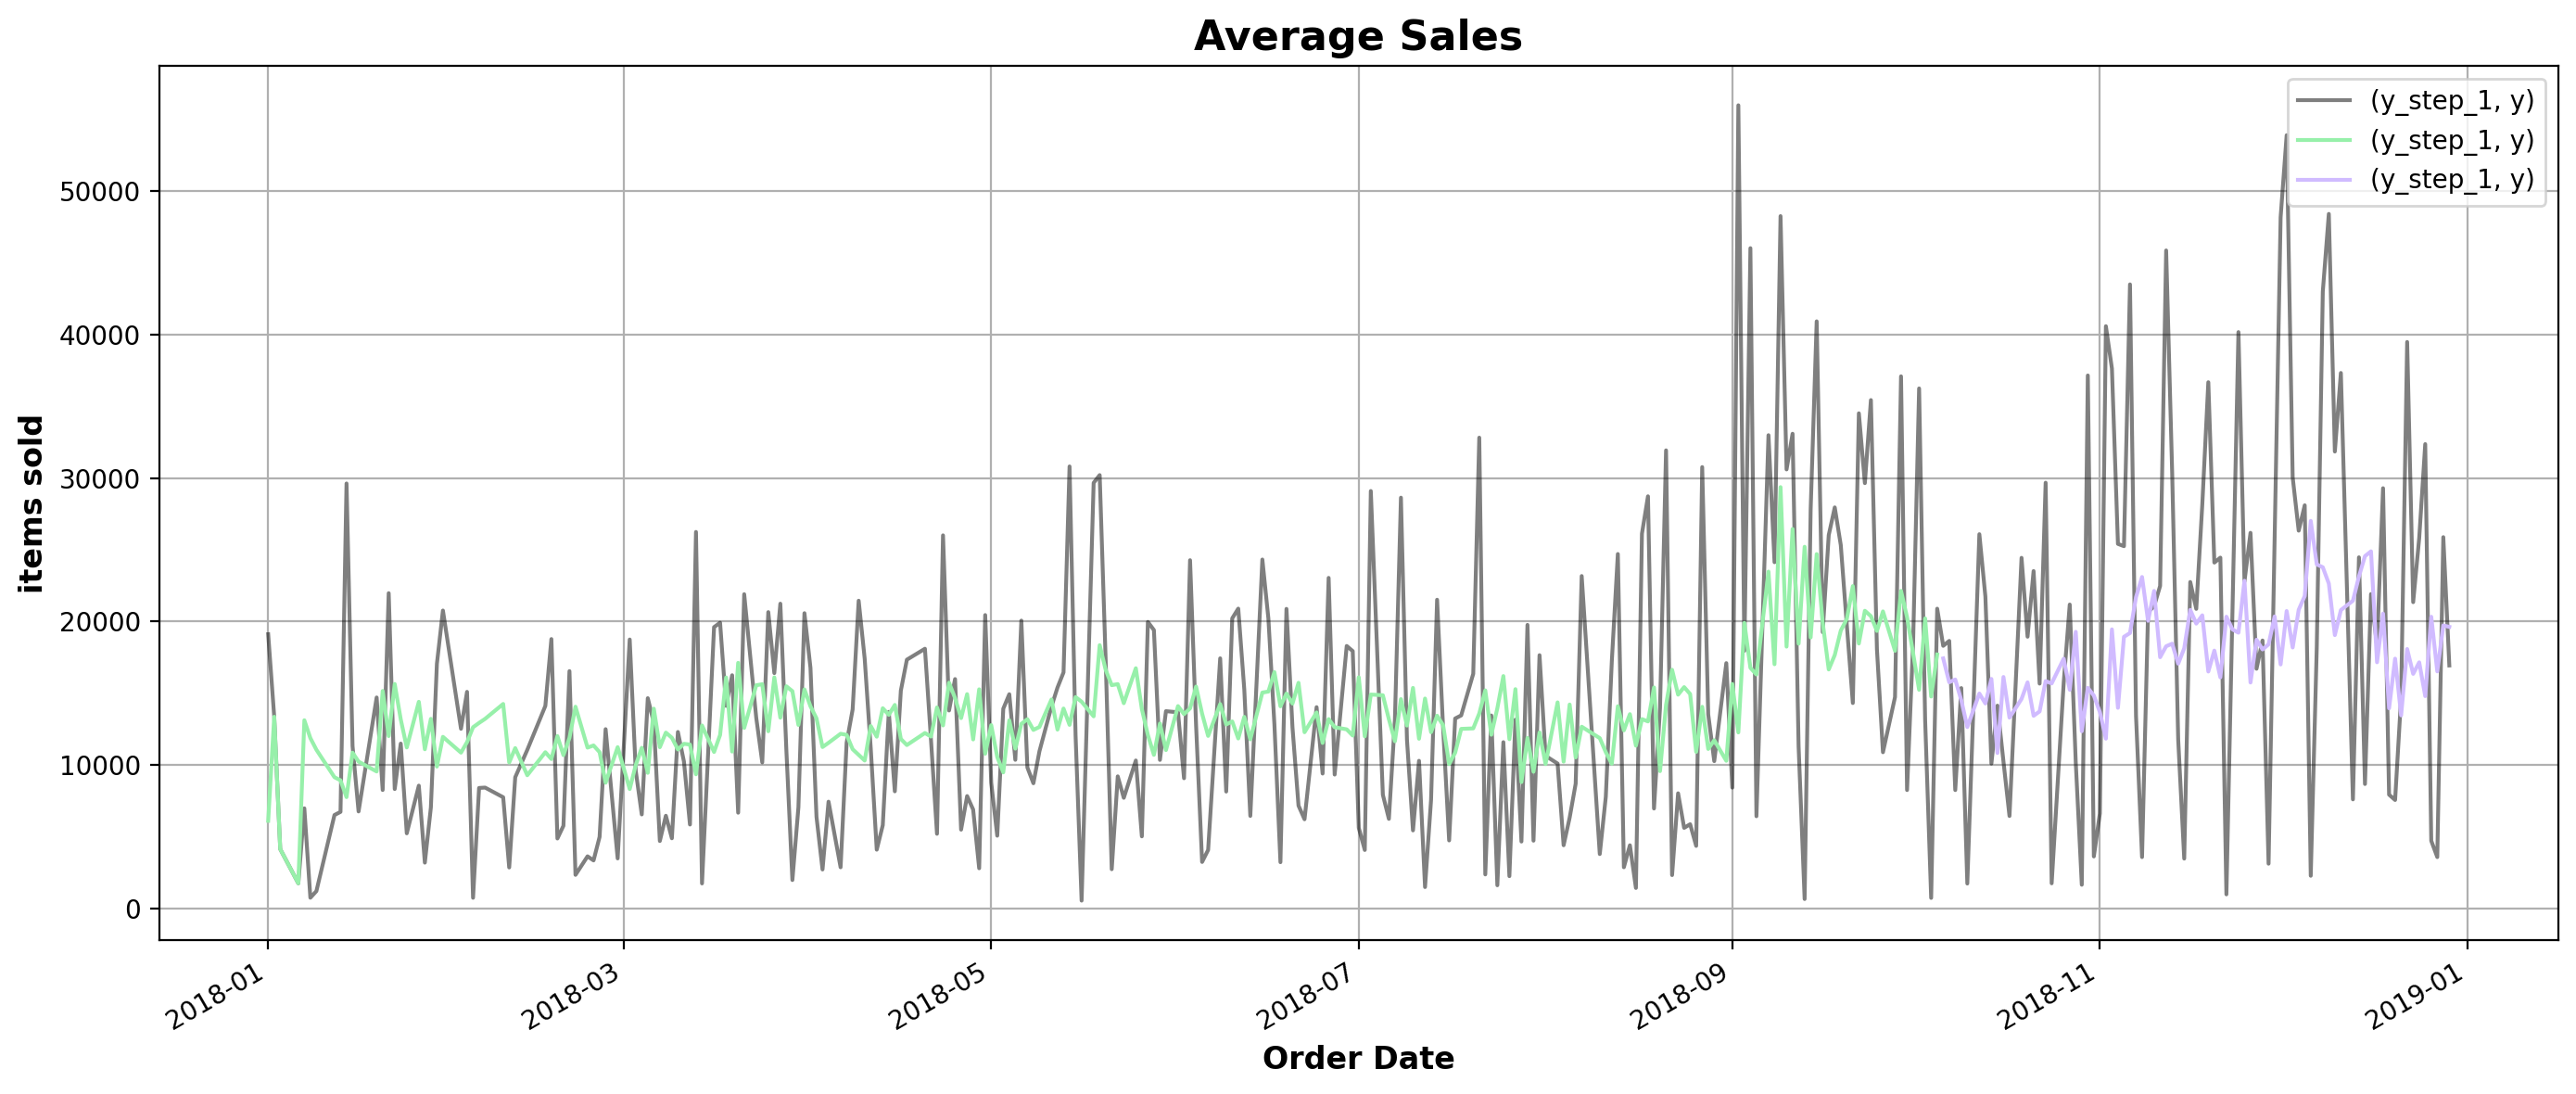

Train Root Mean Square Error: 4783.5
Test Root Mean Square Error: 6562.55


In [56]:
fig, ax = plt.subplots(figsize=(14, 6))
important_columns = [("y_step_1", "y")]
y[important_columns].plot(ax=ax, color="00", alpha=0.5, title="Average Sales", ylabel="items sold")

y_fit[important_columns].plot(ax=ax, label="Fitted", color='C1')
y_pred[important_columns].plot(ax=ax, label="Forecast", color='C3')
ax.legend()
plt.show()

train_rmse = root_mean_squared_error(y_train, y_fit)
test_rmse = root_mean_squared_error(y_test, y_pred)
print((f"Train Root Mean Square Error: {train_rmse:.1f}\n" f"Test Root Mean Square Error: {test_rmse:.2f}"))

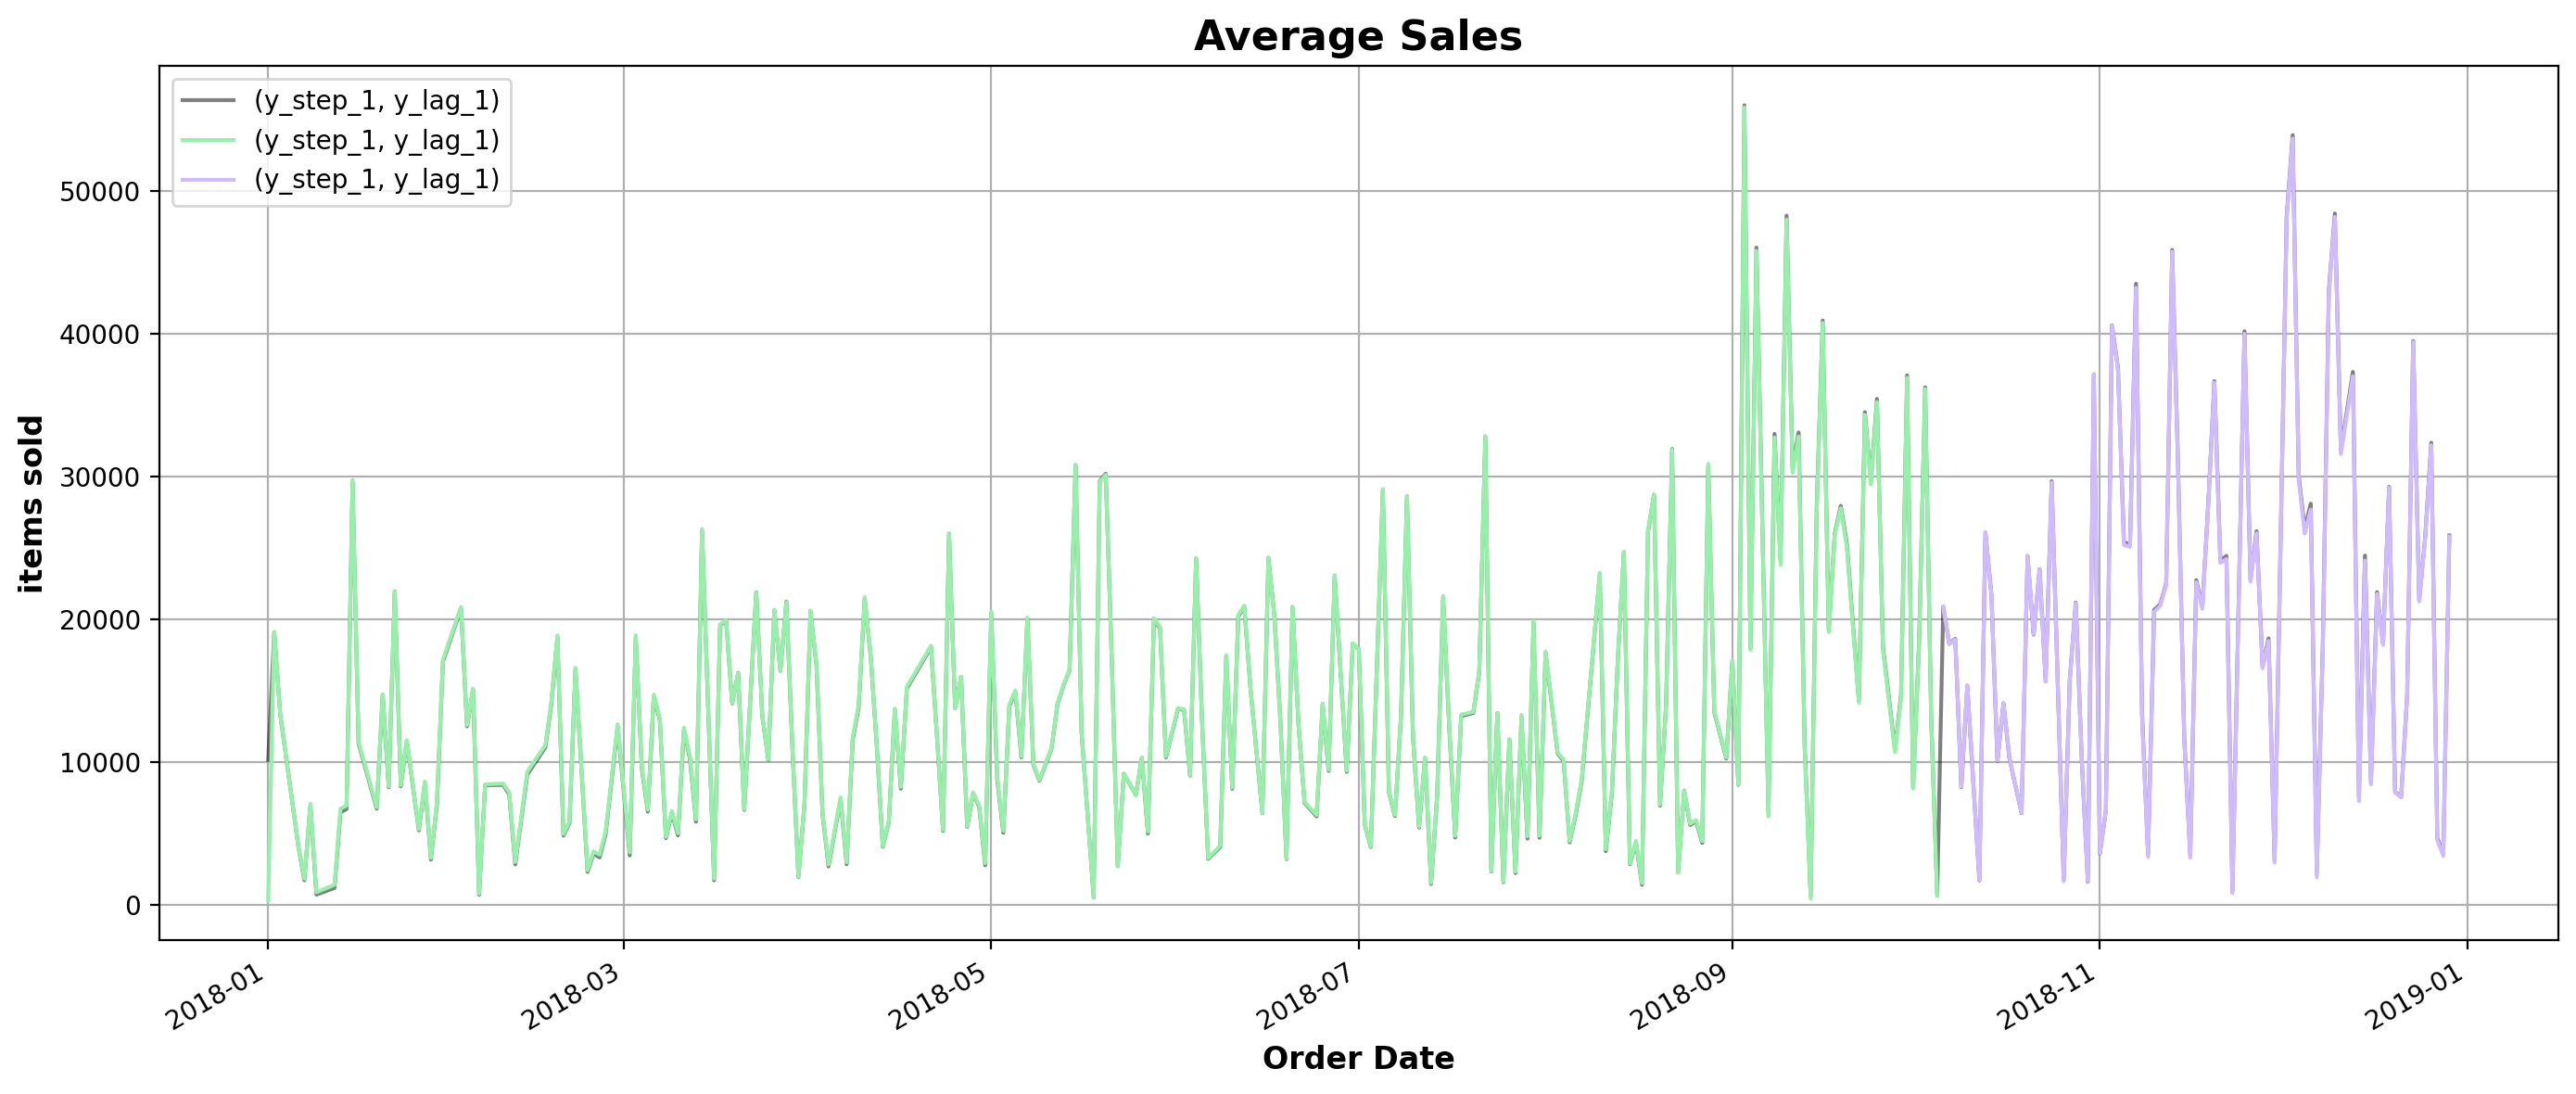

Train Root Mean Square Error: 4783.5
Test Root Mean Square Error: 6562.55


In [48]:
fig, ax = plt.subplots(figsize=(14, 6))
important_columns = [("y_step_1", "y_lag_1")]
y[important_columns].plot(ax=ax, color="00", alpha=0.5, title="Average Sales", ylabel="items sold")

y_fit[important_columns].plot(ax=ax, label="Fitted", color='C1')
y_pred[important_columns].plot(ax=ax, label="Forecast", color='C3')
ax.legend()
plt.show()

train_rmse = root_mean_squared_error(y_train, y_fit)
test_rmse = root_mean_squared_error(y_test, y_pred)
print((f"Train Root Mean Square Error: {train_rmse:.1f}\n" f"Test Root Mean Square Error: {test_rmse:.2f}"))

Finally, I can export this model data to be further synthesized from within Power Bi.

In [21]:
#exporting data for 
y_fit[important_columns].to_csv("fit_graph.csv")
y_pred[important_columns].to_csv("pred_graph.csv")

# Summary

**What I learned**
- I learned how to use Time Series Forecasting to predict sales of a given shop
- I exercised EDA practices like cleaning data
- Used ML algorithms to forecast the sales over a 3 month period.

**Where I could improve**
- Reducing the Root Mean Square Error
- Correcting amplitudes